This file is for evaluating the performance of methods on large tabular datasets.

In [1]:
import openml, os 

root_dir = os.getcwd()
openml.config.set_root_cache_directory(root_dir)

In [2]:
import torch

# Check CUDA availability
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available.
Current CUDA device: 0
Number of CUDA devices: 1
CUDA device name: NVIDIA A100-SXM4-80GB


In [3]:
import matplotlib.pyplot as plt

from mothernet.evaluation.baselines import tabular_baselines

import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore", FutureWarning)  # openml deprecation of array return type
from mothernet.datasets import load_openml_list, open_cc_valid_dids, open_cc_dids, open_cc_large_dids, new_valid_dids
from mothernet.evaluation import tabular_metrics
from mothernet.prediction.tabpfn import TabPFNClassifier
import os
from mothernet.evaluation.baselines.distill_mlp import DistilledTabPFNMLP
from mothernet.prediction.mothernet import MotherNetClassifier
from functools import partial
from mothernet.evaluation.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from mothernet.prediction.mothernet import ShiftClassifier, EnsembleMeta, MotherNetClassifier
from sklearn.impute import SimpleImputer
from mothernet.prediction.mothernet_additive import MotherNetAdditiveClassifier

from interpret.glassbox import ExplainableBoostingClassifier


from hyperfast import HyperFastClassifier

# transformers don't have max times
import warnings
import pandas as pd

import datetime

import pickle

# Datasets

In [4]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(
    new_valid_dids,
    # [1491, 41986, 42343],
    multiclass=True,
    shuffled=True, 
    filter_for_nan=False, 
    max_samples = 1000000, 
    num_feats=5000, 
    return_capped=True,
    max_num_classes=100,
)

Number of datasets: 34


In [5]:
eval_positions = [5000000]
max_features = 5000
n_samples = 1000000
base_path = f'{root_dir}/tabflex/train_tabflex/mothernet'
overwrite = False
# max_times only affect non-nn models, nn models are not affected by max_times
# for non-nn models, when the runtime is longer than the max_time, it should stop
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60] 
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [7]:
cc_test_datasets_multiclass_df['isNumeric'] = (
    cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1
    ) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)

In [8]:
cc_test_datasets_multiclass_df['NumberOfInstances'] =  cc_test_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_test_datasets_multiclass_df['NumberOfFeatures'] =  cc_test_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_test_datasets_multiclass_df['NumberOfClasses'] =  cc_test_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].rename(columns={'NumberOfFeatures': "d", "NumberOfInstances":"n", "NumberOfClasses": "k"}).to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
did & name & d & n & k \\
\midrule
279 & meta_stream_intervals.arff & 75 & 45164 & 11 \\
311 & oil_spill & 50 & 937 & 2 \\
742 & fri_c4_500_100 & 101 & 500 & 2 \\
825 & boston_corrected & 21 & 506 & 2 \\
833 & bank32nh & 33 & 8192 & 2 \\
841 & stock & 10 & 950 & 2 \\
920 & fri_c2_500_50 & 51 & 500 & 2 \\
940 & water-treatment & 37 & 527 & 2 \\
981 & kdd_internet_usage & 69 & 10108 & 2 \\
1039 & hiva_agnostic & 1618 & 4229 & 2 \\
1491 & one-hundred-plants-margin & 65 & 1600 & 100 \\
1492 & one-hundred-plants-shape & 65 & 1600 & 100 \\
1503 & spoken-arabic-digit & 15 & 263256 & 10 \\
1515 & micro-mass & 1301 & 571 & 20 \\
1536 & volcanoes-b6 & 4 & 10130 & 5 \\
1541 & volcanoes-d4 & 4 & 8654 & 5 \\
1549 & autoUniv-au6-750 & 41 & 750 & 8 \\
40645 & GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1 & 1001 & 1600 & 2 \\
40672 & fars & 30 & 100968 & 8 \\
40677 & led24 & 25 & 3200 & 10 \\
40693 & xd6 & 10 & 973 & 2 \\
40705 & tokyo1 & 45 & 959 & 2 \\
40922 & R

In [16]:
preview = cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].reset_index(drop=True)
preview

,did,name,NumberOfFeatures,NumberOfInstances,NumberOfClasses
0,279,meta_stream_intervals.arff,75,45164,11
1,311,oil_spill,50,937,2
2,742,fri_c4_500_100,101,500,2
3,825,boston_corrected,21,506,2
4,833,bank32nh,33,8192,2
5,841,stock,10,950,2
6,920,fri_c2_500_50,51,500,2
7,940,water-treatment,37,527,2
8,981,kdd_internet_usage,69,10108,2
9,1039,hiva_agnostic,1618,4229,2


# Method Evaluation
This section runs baselines and saves results locally.

# TabPFN

In [11]:
max_times = [10000000]
device = "cuda"
output_dir = f'{base_path}/results/tabular/multiclass'
os.makedirs(output_dir, exist_ok=True)

results_tabpfn = []

tabpfn_models = {
    'ssm_tabpfn_b4_largedatasetTrue_modellinear_attention_nsamples50000_08_01_2024_22_05_50': ('TabFast', '110'),
    'prior_diff_real_checkpoint_n_0': ('TabPFN', '100'),
    'ssm_tabpfn_b4_maxnumclasses100_modellinear_attention_numfeatures1000_n1024_validdatanew_warm_08_23_2024_19_25_40': ('TabFlex', '1410'),
    'ssm_tabpfn_modellinear_attention_08_28_2024_19_00_44': ('TabSmall', '1210'),
}

for model_string in tabpfn_models:
    model = TabPFNClassifier(
        device=device, 
        model_string=model_string, 
        epoch=tabpfn_models[model_string][1], 
        N_ensemble_configurations=3,
    )

    result = eval_on_datasets(
        'multiclass', 
        model, 
        tabpfn_models[model_string][0].lower(), 
        cc_test_datasets_multiclass, 
        eval_positions=eval_positions, 
        max_times=max_times,
        metric_used=metric_used, 
        split_numbers=[1, 2, 3, 4, 5],
        n_samples=n_samples, 
        base_path=base_path, 
        overwrite=False, 
        fetch_only=True,
        n_jobs=1, 
        device=device,
    )
    
    results_tabpfn.append(result)


# store the results as pickle
with open(f'{output_dir}/tabpfn_summary.pkl', 'wb') as f:
    pickle.dump(results_tabpfn, f)
    

evaluating tabfast on cuda


evaluating tabfast on cuda meta_stream_intervals.arff:   0%|          | 0/170 [00:00<?, ?it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_1_cuda.npy


evaluating tabfast on cuda meta_stream_intervals.arff:   1%|          | 2/170 [00:00<00:48,  3.43it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_3_cuda.npy


evaluating tabfast on cuda meta_stream_intervals.arff:   2%|▏         | 4/170 [00:01<00:39,  4.25it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_4_cuda.npy


evaluating tabfast on cuda oil_spill:   3%|▎         | 5/170 [00:01<00:36,  4.49it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_oil_spill_468_936_1_cuda.npy


evaluating tabfast on cuda fri_c2_500_50:  19%|█▉        | 32/170 [00:01<00:02, 50.56it/s]   

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_oil_spill_468_936_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_oil_spill_468_936_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_oil_spill_468_936_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_oil_spill_468_936_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_ro

evaluating tabfast on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:01<00:01, 67.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fri_c2_500_50_250_500_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fri_c2_500_50_250_500_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_water-treatment_263_526_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_water-treatment_263_526_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabf

evaluating tabfast on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:06<00:01, 67.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_2_cuda.npy


evaluating tabfast on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:10<00:01, 67.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_3_cuda.npy


evaluating tabfast on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:14<00:01, 67.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_4_cuda.npy


evaluating tabfast on cuda one-hundred-plants-margin:  32%|███▏      | 54/170 [00:19<01:08,  1.68it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_5_cuda.npy


evaluating tabfast on cuda one-hundred-plants-shape:  32%|███▏      | 55/170 [00:23<01:28,  1.31it/s] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_1_cuda.npy


evaluating tabfast on cuda one-hundred-plants-shape:  32%|███▏      | 55/170 [00:27<01:28,  1.31it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_2_cuda.npy


evaluating tabfast on cuda one-hundred-plants-shape:  32%|███▏      | 55/170 [00:32<01:28,  1.31it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_3_cuda.npy


evaluating tabfast on cuda one-hundred-plants-shape:  32%|███▏      | 55/170 [00:36<01:28,  1.31it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_4_cuda.npy


evaluating tabfast on cuda one-hundred-plants-shape:  35%|███▍      | 59/170 [00:40<02:46,  1.50s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_5_cuda.npy


evaluating tabfast on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:45<03:06,  1.70s/it]     

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_1_cuda.npy


evaluating tabfast on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:45<03:06,  1.70s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_2_cuda.npy


evaluating tabfast on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:46<03:06,  1.70s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_3_cuda.npy


evaluating tabfast on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:47<03:06,  1.70s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_4_cuda.npy


evaluating tabfast on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:47<03:06,  1.70s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_5_cuda.npy


evaluating tabfast on cuda micro-mass:  38%|███▊      | 65/170 [00:48<02:20,  1.34s/it]         

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_micro-mass_285_570_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_micro-mass_285_570_2_cuda.npy


evaluating tabfast on cuda micro-mass:  40%|████      | 68/170 [00:48<01:50,  1.09s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_micro-mass_285_570_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_micro-mass_285_570_4_cuda.npy


evaluating tabfast on cuda volcanoes-b6:  42%|████▏     | 71/170 [00:49<01:24,  1.17it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_micro-mass_285_570_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-b6_5065_10130_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-b6_5065_10130_2_cuda.npy


evaluating tabfast on cuda autoUniv-au6-750:  45%|████▍     | 76/170 [00:49<00:52,  1.80it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-b6_5065_10130_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-b6_5065_10130_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-b6_5065_10130_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_volcanoes-d4_4327_8654_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_t

evaluating tabfast on cuda fars:  50%|█████     | 85/170 [00:49<00:23,  3.60it/s]                                               

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_autoUniv-au6-750_375_750_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_autoUniv-au6-750_375_750_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_autoUniv-au6-750_375_750_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_autoUniv-au6-750_375_750_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/resu

evaluating tabfast on cuda fars:  54%|█████▎    | 91/170 [00:49<00:15,  5.26it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fars_50484_100968_2_cuda.npy


evaluating tabfast on cuda fars:  54%|█████▎    | 91/170 [00:50<00:15,  5.26it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fars_50484_100968_3_cuda.npy


evaluating tabfast on cuda fars:  54%|█████▎    | 91/170 [00:50<00:15,  5.26it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fars_50484_100968_4_cuda.npy


evaluating tabfast on cuda fars:  55%|█████▌    | 94/170 [00:50<00:14,  5.09it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_fars_50484_100968_5_cuda.npy


evaluating tabfast on cuda led24:  57%|█████▋    | 97/170 [00:50<00:12,  5.67it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_led24_1600_3200_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_led24_1600_3200_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_led24_1600_3200_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_led24_1600_3200_4_cuda.npy


evaluating tabfast on cuda Run_or_walk_information:  63%|██████▎   | 107/170 [00:51<00:05, 12.12it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_led24_1600_3200_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_xd6_486_972_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_xd6_486_972_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_xd6_486_972_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_xd6_486_972_4_

evaluating tabfast on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 17.81it/s]  

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Run_or_walk_information_44294_88588_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_1_cuda.npy


evaluating tabfast on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 17.81it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_2_cuda.npy


evaluating tabfast on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 17.81it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_3_cuda.npy


evaluating tabfast on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:52<00:03, 17.81it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_4_cuda.npy


evaluating tabfast on cuda tamilnadu-electricity:  70%|███████   | 119/170 [00:52<00:06,  7.51it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_5_cuda.npy


evaluating tabfast on cuda USPS:  70%|███████   | 119/170 [00:53<00:06,  7.51it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_USPS_4649_9298_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_USPS_4649_9298_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_USPS_4649_9298_3_cuda.npy


evaluating tabfast on cuda USPS:  72%|███████▏  | 123/170 [00:53<00:06,  7.01it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_USPS_4649_9298_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_USPS_4649_9298_5_cuda.npy


evaluating tabfast on cuda GTSRB-HOG01:  74%|███████▍  | 126/170 [00:53<00:05,  7.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_madeline_1570_3140_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_madeline_1570_3140_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_madeline_1570_3140_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_madeline_1570_3140_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_1000000

evaluating tabfast on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:55<00:06,  5.61it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_2_cuda.npy


evaluating tabfast on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:56<00:06,  5.61it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_3_cuda.npy


evaluating tabfast on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:57<00:13,  2.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_4_cuda.npy


evaluating tabfast on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:59<00:13,  2.76it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_5_cuda.npy


evaluating tabfast on cuda GTSRB-HOG02:  79%|███████▉  | 135/170 [01:00<00:19,  1.84it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_1_cuda.npy


evaluating tabfast on cuda GTSRB-HOG02:  80%|████████  | 136/170 [01:01<00:21,  1.56it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_2_cuda.npy


evaluating tabfast on cuda GTSRB-HOG02:  81%|████████  | 137/170 [01:03<00:25,  1.32it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_3_cuda.npy


evaluating tabfast on cuda GTSRB-HOG02:  81%|████████  | 138/170 [01:04<00:27,  1.16it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_4_cuda.npy


evaluating tabfast on cuda GTSRB-HOG02:  82%|████████▏ | 139/170 [01:06<00:29,  1.05it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_5_cuda.npy


evaluating tabfast on cuda GTSRB-HOG03:  82%|████████▏ | 140/170 [01:07<00:31,  1.04s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_1_cuda.npy


evaluating tabfast on cuda GTSRB-HOG03:  83%|████████▎ | 141/170 [01:08<00:32,  1.10s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_2_cuda.npy


evaluating tabfast on cuda GTSRB-HOG03:  84%|████████▎ | 142/170 [01:09<00:32,  1.16s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_3_cuda.npy


evaluating tabfast on cuda GTSRB-HOG03:  84%|████████▍ | 143/170 [01:11<00:32,  1.21s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_4_cuda.npy


evaluating tabfast on cuda GTSRB-HOG03:  85%|████████▍ | 144/170 [01:12<00:32,  1.25s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_5_cuda.npy


evaluating tabfast on cuda GTSRB-HueHist:  85%|████████▌ | 145/170 [01:13<00:31,  1.27s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_1_cuda.npy


evaluating tabfast on cuda GTSRB-HueHist:  86%|████████▌ | 146/170 [01:15<00:30,  1.29s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_2_cuda.npy


evaluating tabfast on cuda GTSRB-HueHist:  86%|████████▋ | 147/170 [01:16<00:29,  1.30s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_3_cuda.npy


evaluating tabfast on cuda GTSRB-HueHist:  87%|████████▋ | 148/170 [01:17<00:28,  1.31s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_4_cuda.npy


evaluating tabfast on cuda GTSRB-HueHist:  88%|████████▊ | 149/170 [01:19<00:27,  1.31s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_5_cuda.npy


evaluating tabfast on cuda Kuzushiji-49:  88%|████████▊ | 150/170 [01:20<00:26,  1.32s/it] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Kuzushiji-49_135456_270912_1_cuda.npy


evaluating tabfast on cuda Kuzushiji-49:  89%|████████▉ | 151/170 [01:24<00:38,  2.03s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Kuzushiji-49_135456_270912_2_cuda.npy


evaluating tabfast on cuda Kuzushiji-49:  89%|████████▉ | 152/170 [01:28<00:45,  2.53s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Kuzushiji-49_135456_270912_3_cuda.npy


evaluating tabfast on cuda Kuzushiji-49:  90%|█████████ | 153/170 [01:31<00:48,  2.87s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Kuzushiji-49_135456_270912_4_cuda.npy


evaluating tabfast on cuda Kuzushiji-49:  91%|█████████ | 154/170 [01:35<00:49,  3.12s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_Kuzushiji-49_135456_270912_5_cuda.npy


evaluating tabfast on cuda porto-seguro:  91%|█████████ | 155/170 [01:39<00:49,  3.28s/it]    

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_compas-two-years_2639_5278_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_compas-two-years_2639_5278_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_compas-two-years_2639_5278_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_compas-two-years_2639_5278_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multicl

evaluating tabfast on cuda porto-seguro:  95%|█████████▌| 162/170 [01:39<00:06,  1.19it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_porto-seguro_297606_595212_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_porto-seguro_297606_595212_3_cuda.npy


evaluating tabfast on cuda porto-seguro:  96%|█████████▋| 164/170 [01:39<00:03,  1.61it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_porto-seguro_297606_595212_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_porto-seguro_297606_595212_5_cuda.npy


evaluating tabfast on cuda KDD98: 100%|██████████| 170/170 [01:40<00:00,  1.70it/s]       


Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_KDD98_41159_82318_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_KDD98_41159_82318_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_KDD98_41159_82318_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_roc_auc_KDD98_41159_82318_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfast_time_10000000_ro

evaluating tabpfn on cuda meta_stream_intervals.arff:   0%|          | 0/170 [00:00<?, ?it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_1_cuda.npy


evaluating tabpfn on cuda meta_stream_intervals.arff:   1%|          | 2/170 [00:00<00:34,  4.90it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_2_cuda.npy


evaluating tabpfn on cuda meta_stream_intervals.arff:   2%|▏         | 3/170 [00:00<00:33,  4.92it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_3_cuda.npy


evaluating tabpfn on cuda meta_stream_intervals.arff:   2%|▏         | 4/170 [00:00<00:33,  4.93it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_4_cuda.npy


evaluating tabpfn on cuda oil_spill:   3%|▎         | 5/170 [00:01<00:33,  4.93it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_oil_spill_468_936_1_cuda.npy


evaluating tabpfn on cuda fri_c2_500_50:  18%|█▊        | 31/170 [00:01<00:02, 51.71it/s]   

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_oil_spill_468_936_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_oil_spill_468_936_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_oil_spill_468_936_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_oil_spill_468_936_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc

evaluating tabpfn on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:01<00:01, 69.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fri_c2_500_50_250_500_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fri_c2_500_50_250_500_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fri_c2_500_50_250_500_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_water-treatment_263_526_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_tim

evaluating tabpfn on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:05<00:01, 69.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_2_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:10<00:01, 69.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_3_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-margin:  31%|███       | 53/170 [00:14<00:52,  2.21it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_4_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-margin:  32%|███▏      | 54/170 [00:18<01:13,  1.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_5_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-shape:  32%|███▏      | 54/170 [00:23<01:13,  1.58it/s] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_1_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-shape:  32%|███▏      | 54/170 [00:27<01:13,  1.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_2_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-shape:  34%|███▎      | 57/170 [00:31<02:21,  1.25s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_3_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-shape:  34%|███▍      | 58/170 [00:36<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_4_cuda.npy


evaluating tabpfn on cuda one-hundred-plants-shape:  34%|███▍      | 58/170 [00:40<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_5_cuda.npy


evaluating tabpfn on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:44<02:44,  1.47s/it]     

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_1_cuda.npy


evaluating tabpfn on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:45<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_2_cuda.npy


evaluating tabpfn on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:46<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_3_cuda.npy


evaluating tabpfn on cuda spoken-arabic-digit:  37%|███▋      | 63/170 [00:46<03:00,  1.69s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_4_cuda.npy


evaluating tabpfn on cuda spoken-arabic-digit:  38%|███▊      | 64/170 [00:47<02:48,  1.59s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_5_cuda.npy


evaluating tabpfn on cuda micro-mass:  38%|███▊      | 64/170 [00:48<02:48,  1.59s/it]         

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_micro-mass_285_570_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_micro-mass_285_570_2_cuda.npy


evaluating tabpfn on cuda micro-mass:  39%|███▉      | 67/170 [00:48<02:07,  1.24s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_micro-mass_285_570_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_micro-mass_285_570_4_cuda.npy


evaluating tabpfn on cuda volcanoes-b6:  41%|████      | 70/170 [00:48<01:33,  1.07it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_micro-mass_285_570_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-b6_5065_10130_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-b6_5065_10130_2_cuda.npy


evaluating tabpfn on cuda autoUniv-au6-750:  47%|████▋     | 80/170 [00:49<00:33,  2.70it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-b6_5065_10130_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-b6_5065_10130_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-b6_5065_10130_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_volcanoes-d4_4327_8654_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpf

evaluating tabpfn on cuda fars:  49%|████▉     | 84/170 [00:49<00:23,  3.69it/s]                                               

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_autoUniv-au6-750_375_750_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_autoUniv-au6-750_375_750_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_autoUniv-au6-750_375_750_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_autoUniv-au6-750_375_750_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_

evaluating tabpfn on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fars_50484_100968_2_cuda.npy


evaluating tabpfn on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fars_50484_100968_3_cuda.npy


evaluating tabpfn on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fars_50484_100968_4_cuda.npy


evaluating tabpfn on cuda fars:  55%|█████▌    | 94/170 [00:50<00:14,  5.38it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_fars_50484_100968_5_cuda.npy


evaluating tabpfn on cuda led24:  57%|█████▋    | 97/170 [00:50<00:12,  5.92it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_led24_1600_3200_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_led24_1600_3200_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_led24_1600_3200_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_led24_1600_3200_4_cuda.npy


evaluating tabpfn on cuda Run_or_walk_information:  63%|██████▎   | 107/170 [00:50<00:05, 12.48it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_led24_1600_3200_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_xd6_486_972_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_xd6_486_972_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_xd6_486_972_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_xd6_486_972_4_cuda.

evaluating tabpfn on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:50<00:03, 18.24it/s]  

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Run_or_walk_information_44294_88588_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_1_cuda.npy


evaluating tabpfn on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 18.24it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_2_cuda.npy


evaluating tabpfn on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 18.24it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_3_cuda.npy


evaluating tabpfn on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:52<00:03, 18.24it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_4_cuda.npy


evaluating tabpfn on cuda tamilnadu-electricity:  70%|███████   | 119/170 [00:52<00:06,  7.57it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_5_cuda.npy


evaluating tabpfn on cuda USPS:  70%|███████   | 119/170 [00:53<00:06,  7.57it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_USPS_4649_9298_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_USPS_4649_9298_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_USPS_4649_9298_3_cuda.npy


evaluating tabpfn on cuda madeline:  74%|███████▍  | 126/170 [00:53<00:05,  7.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_USPS_4649_9298_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_USPS_4649_9298_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_madeline_1570_3140_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_madeline_1570_3140_2_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG01:  74%|███████▍  | 126/170 [00:53<00:05,  7.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_madeline_1570_3140_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_madeline_1570_3140_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_madeline_1570_3140_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_1_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:54<00:06,  5.73it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_2_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:56<00:06,  5.73it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_3_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:57<00:13,  2.80it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_4_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:58<00:13,  2.80it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_5_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG02:  79%|███████▉  | 135/170 [00:59<00:18,  1.87it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_1_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG02:  80%|████████  | 136/170 [01:01<00:21,  1.56it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_2_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG02:  81%|████████  | 137/170 [01:02<00:24,  1.36it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_3_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG02:  81%|████████  | 138/170 [01:04<00:26,  1.20it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_4_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG02:  82%|████████▏ | 139/170 [01:05<00:29,  1.05it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_5_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG03:  82%|████████▏ | 140/170 [01:06<00:31,  1.04s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_1_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG03:  83%|████████▎ | 141/170 [01:08<00:32,  1.11s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_2_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG03:  84%|████████▎ | 142/170 [01:09<00:32,  1.17s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_3_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG03:  84%|████████▍ | 143/170 [01:10<00:32,  1.21s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_4_cuda.npy


evaluating tabpfn on cuda GTSRB-HOG03:  85%|████████▍ | 144/170 [01:12<00:32,  1.24s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_5_cuda.npy


evaluating tabpfn on cuda GTSRB-HueHist:  85%|████████▌ | 145/170 [01:13<00:31,  1.26s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_1_cuda.npy


evaluating tabpfn on cuda GTSRB-HueHist:  86%|████████▌ | 146/170 [01:14<00:30,  1.28s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_2_cuda.npy


evaluating tabpfn on cuda GTSRB-HueHist:  86%|████████▋ | 147/170 [01:16<00:29,  1.30s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_3_cuda.npy


evaluating tabpfn on cuda GTSRB-HueHist:  87%|████████▋ | 148/170 [01:17<00:28,  1.31s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_4_cuda.npy


evaluating tabpfn on cuda GTSRB-HueHist:  88%|████████▊ | 149/170 [01:18<00:27,  1.31s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_5_cuda.npy


evaluating tabpfn on cuda Kuzushiji-49:  88%|████████▊ | 150/170 [01:20<00:26,  1.32s/it] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Kuzushiji-49_135456_270912_1_cuda.npy


evaluating tabpfn on cuda Kuzushiji-49:  89%|████████▉ | 151/170 [01:23<00:38,  2.04s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Kuzushiji-49_135456_270912_2_cuda.npy


evaluating tabpfn on cuda Kuzushiji-49:  89%|████████▉ | 152/170 [01:27<00:45,  2.54s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Kuzushiji-49_135456_270912_3_cuda.npy


evaluating tabpfn on cuda Kuzushiji-49:  90%|█████████ | 153/170 [01:31<00:49,  2.89s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Kuzushiji-49_135456_270912_4_cuda.npy


evaluating tabpfn on cuda Kuzushiji-49:  91%|█████████ | 154/170 [01:35<00:50,  3.14s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_Kuzushiji-49_135456_270912_5_cuda.npy


evaluating tabpfn on cuda porto-seguro:  91%|█████████ | 155/170 [01:38<00:49,  3.31s/it]    

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_compas-two-years_2639_5278_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_compas-two-years_2639_5278_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_compas-two-years_2639_5278_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_compas-two-years_2639_5278_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/

evaluating tabpfn on cuda porto-seguro:  95%|█████████▌| 162/170 [01:39<00:06,  1.19it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_porto-seguro_297606_595212_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_porto-seguro_297606_595212_3_cuda.npy


evaluating tabpfn on cuda porto-seguro:  96%|█████████▋| 164/170 [01:39<00:03,  1.60it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_porto-seguro_297606_595212_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_porto-seguro_297606_595212_5_cuda.npy


evaluating tabpfn on cuda KDD98: 100%|██████████| 170/170 [01:39<00:00,  1.70it/s]       


Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_KDD98_41159_82318_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_KDD98_41159_82318_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_KDD98_41159_82318_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc_KDD98_41159_82318_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabpfn_time_10000000_roc_auc

evaluating tabflex on cuda meta_stream_intervals.arff:   0%|          | 0/170 [00:00<?, ?it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_1_cuda.npy


evaluating tabflex on cuda meta_stream_intervals.arff:   1%|          | 2/170 [00:00<00:34,  4.92it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_2_cuda.npy


evaluating tabflex on cuda meta_stream_intervals.arff:   2%|▏         | 3/170 [00:00<00:33,  4.94it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_3_cuda.npy


evaluating tabflex on cuda meta_stream_intervals.arff:   2%|▏         | 4/170 [00:00<00:33,  4.95it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_5_cuda.npy


evaluating tabflex on cuda fri_c2_500_50:  19%|█▉        | 32/170 [00:01<00:02, 53.82it/s]            

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_oil_spill_468_936_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_oil_spill_468_936_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_oil_spill_468_936_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_oil_spill_468_936_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_ro

evaluating tabflex on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:01<00:01, 71.97it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fri_c2_500_50_250_500_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fri_c2_500_50_250_500_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fri_c2_500_50_250_500_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_water-treatment_263_526_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabfle

evaluating tabflex on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:05<00:01, 71.97it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_2_cuda.npy


evaluating tabflex on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:10<00:01, 71.97it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_3_cuda.npy


evaluating tabflex on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:15<00:01, 71.97it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_4_cuda.npy


evaluating tabflex on cuda one-hundred-plants-margin:  26%|██▋       | 45/170 [00:19<00:01, 71.97it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_5_cuda.npy


evaluating tabflex on cuda one-hundred-plants-shape:  32%|███▏      | 55/170 [00:24<01:26,  1.33it/s] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_1_cuda.npy


evaluating tabflex on cuda one-hundred-plants-shape:  33%|███▎      | 56/170 [00:28<01:44,  1.09it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_2_cuda.npy


evaluating tabflex on cuda one-hundred-plants-shape:  33%|███▎      | 56/170 [00:33<01:44,  1.09it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_3_cuda.npy


evaluating tabflex on cuda one-hundred-plants-shape:  33%|███▎      | 56/170 [00:37<01:44,  1.09it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_4_cuda.npy


evaluating tabflex on cuda one-hundred-plants-shape:  35%|███▍      | 59/170 [00:42<02:46,  1.50s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_5_cuda.npy


evaluating tabflex on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:47<03:08,  1.71s/it]     

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_1_cuda.npy


evaluating tabflex on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:47<03:08,  1.71s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_2_cuda.npy


evaluating tabflex on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:48<03:08,  1.71s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_3_cuda.npy


evaluating tabflex on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:49<03:08,  1.71s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_4_cuda.npy


evaluating tabflex on cuda spoken-arabic-digit:  35%|███▌      | 60/170 [00:49<03:08,  1.71s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_5_cuda.npy


evaluating tabflex on cuda micro-mass:  38%|███▊      | 65/170 [00:50<02:21,  1.34s/it]         

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_micro-mass_285_570_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_micro-mass_285_570_2_cuda.npy


evaluating tabflex on cuda micro-mass:  38%|███▊      | 65/170 [00:50<02:21,  1.34s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_micro-mass_285_570_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_micro-mass_285_570_4_cuda.npy


evaluating tabflex on cuda volcanoes-b6:  41%|████      | 69/170 [00:51<01:43,  1.02s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_micro-mass_285_570_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_volcanoes-b6_5065_10130_1_cuda.npy


evaluating tabflex on cuda autoUniv-au6-750:  45%|████▌     | 77/170 [00:51<00:49,  1.88it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_volcanoes-b6_5065_10130_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_volcanoes-b6_5065_10130_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_volcanoes-b6_5065_10130_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_volcanoes-b6_5065_10130_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_

evaluating tabflex on cuda GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1:  50%|█████     | 85/170 [00:51<00:24,  3.52it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_autoUniv-au6-750_375_750_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_autoUniv-au6-750_375_750_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_autoUniv-au6-750_375_750_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_autoUniv-au6-750_375_750_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/resu

evaluating tabflex on cuda fars:  50%|█████     | 85/170 [00:51<00:24,  3.52it/s]                                               

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1_800_1600_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fars_50484_100968_1_cuda.npy


evaluating tabflex on cuda fars:  54%|█████▎    | 91/170 [00:51<00:15,  5.20it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fars_50484_100968_2_cuda.npy


evaluating tabflex on cuda fars:  54%|█████▎    | 91/170 [00:52<00:15,  5.20it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fars_50484_100968_3_cuda.npy


evaluating tabflex on cuda fars:  54%|█████▎    | 91/170 [00:52<00:15,  5.20it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fars_50484_100968_4_cuda.npy


evaluating tabflex on cuda fars:  55%|█████▌    | 94/170 [00:52<00:15,  5.02it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_fars_50484_100968_5_cuda.npy


evaluating tabflex on cuda led24:  57%|█████▋    | 97/170 [00:52<00:13,  5.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_led24_1600_3200_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_led24_1600_3200_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_led24_1600_3200_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_led24_1600_3200_4_cuda.npy


evaluating tabflex on cuda Run_or_walk_information:  63%|██████▎   | 107/170 [00:53<00:05, 12.02it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_led24_1600_3200_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_xd6_486_972_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_xd6_486_972_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_xd6_486_972_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_xd6_486_972_4_

evaluating tabflex on cuda tamilnadu-electricity:  68%|██████▊   | 115/170 [00:53<00:02, 18.37it/s]  

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Run_or_walk_information_44294_88588_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_1_cuda.npy


evaluating tabflex on cuda tamilnadu-electricity:  68%|██████▊   | 115/170 [00:53<00:02, 18.37it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_2_cuda.npy


evaluating tabflex on cuda tamilnadu-electricity:  68%|██████▊   | 115/170 [00:54<00:02, 18.37it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_3_cuda.npy


evaluating tabflex on cuda tamilnadu-electricity:  68%|██████▊   | 115/170 [00:54<00:02, 18.37it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_4_cuda.npy


evaluating tabflex on cuda tamilnadu-electricity:  68%|██████▊   | 115/170 [00:54<00:02, 18.37it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_5_cuda.npy


evaluating tabflex on cuda USPS:  71%|███████   | 120/170 [00:55<00:08,  6.16it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_USPS_4649_9298_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_USPS_4649_9298_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_USPS_4649_9298_3_cuda.npy


evaluating tabflex on cuda madeline:  75%|███████▍  | 127/170 [00:55<00:05,  8.12it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_USPS_4649_9298_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_USPS_4649_9298_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_madeline_1570_3140_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_madeline_1570_3140_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_au

evaluating tabflex on cuda GTSRB-HOG01:  75%|███████▍  | 127/170 [00:55<00:05,  8.12it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_madeline_1570_3140_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_madeline_1570_3140_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_1_cuda.npy


evaluating tabflex on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:57<00:07,  5.12it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_2_cuda.npy


evaluating tabflex on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:58<00:07,  5.12it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_3_cuda.npy


evaluating tabflex on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [01:00<00:15,  2.44it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_4_cuda.npy


evaluating tabflex on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [01:01<00:15,  2.44it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_5_cuda.npy


evaluating tabflex on cuda GTSRB-HOG02:  79%|███████▉  | 135/170 [01:03<00:22,  1.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_1_cuda.npy


evaluating tabflex on cuda GTSRB-HOG02:  80%|████████  | 136/170 [01:05<00:24,  1.36it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_2_cuda.npy


evaluating tabflex on cuda GTSRB-HOG02:  81%|████████  | 137/170 [01:06<00:27,  1.19it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_3_cuda.npy


evaluating tabflex on cuda GTSRB-HOG02:  81%|████████  | 138/170 [01:07<00:30,  1.05it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_4_cuda.npy


evaluating tabflex on cuda GTSRB-HOG02:  82%|████████▏ | 139/170 [01:09<00:32,  1.06s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_5_cuda.npy


evaluating tabflex on cuda GTSRB-HOG03:  82%|████████▏ | 140/170 [01:10<00:34,  1.15s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_1_cuda.npy


evaluating tabflex on cuda GTSRB-HOG03:  83%|████████▎ | 141/170 [01:12<00:35,  1.23s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_2_cuda.npy


evaluating tabflex on cuda GTSRB-HOG03:  84%|████████▎ | 142/170 [01:13<00:36,  1.29s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_3_cuda.npy


evaluating tabflex on cuda GTSRB-HOG03:  84%|████████▍ | 143/170 [01:15<00:36,  1.34s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_4_cuda.npy


evaluating tabflex on cuda GTSRB-HOG03:  85%|████████▍ | 144/170 [01:16<00:35,  1.38s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_5_cuda.npy


evaluating tabflex on cuda GTSRB-HueHist:  85%|████████▌ | 145/170 [01:18<00:35,  1.41s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_1_cuda.npy


evaluating tabflex on cuda GTSRB-HueHist:  86%|████████▌ | 146/170 [01:19<00:34,  1.43s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_2_cuda.npy


evaluating tabflex on cuda GTSRB-HueHist:  86%|████████▋ | 147/170 [01:21<00:32,  1.43s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_3_cuda.npy


evaluating tabflex on cuda GTSRB-HueHist:  87%|████████▋ | 148/170 [01:22<00:31,  1.43s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_4_cuda.npy


evaluating tabflex on cuda GTSRB-HueHist:  88%|████████▊ | 149/170 [01:24<00:30,  1.43s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_5_cuda.npy


evaluating tabflex on cuda Kuzushiji-49:  88%|████████▊ | 150/170 [01:25<00:28,  1.43s/it] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Kuzushiji-49_135456_270912_1_cuda.npy


evaluating tabflex on cuda Kuzushiji-49:  89%|████████▉ | 151/170 [01:30<00:44,  2.35s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Kuzushiji-49_135456_270912_2_cuda.npy


evaluating tabflex on cuda Kuzushiji-49:  89%|████████▉ | 152/170 [01:34<00:53,  3.00s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Kuzushiji-49_135456_270912_3_cuda.npy


evaluating tabflex on cuda Kuzushiji-49:  90%|█████████ | 153/170 [01:39<00:58,  3.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Kuzushiji-49_135456_270912_4_cuda.npy


evaluating tabflex on cuda Kuzushiji-49:  91%|█████████ | 154/170 [01:43<01:01,  3.82s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_Kuzushiji-49_135456_270912_5_cuda.npy


evaluating tabflex on cuda porto-seguro:  91%|█████████ | 155/170 [01:48<01:01,  4.07s/it]    

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_compas-two-years_2639_5278_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_compas-two-years_2639_5278_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_compas-two-years_2639_5278_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_compas-two-years_2639_5278_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multicl

evaluating tabflex on cuda porto-seguro:  95%|█████████▌| 162/170 [01:48<00:08,  1.03s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_porto-seguro_297606_595212_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_porto-seguro_297606_595212_3_cuda.npy


evaluating tabflex on cuda porto-seguro:  96%|█████████▋| 164/170 [01:49<00:04,  1.34it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_porto-seguro_297606_595212_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_porto-seguro_297606_595212_5_cuda.npy


evaluating tabflex on cuda KDD98: 100%|██████████| 170/170 [01:49<00:00,  1.55it/s]       


Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_KDD98_41159_82318_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_KDD98_41159_82318_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_KDD98_41159_82318_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_roc_auc_KDD98_41159_82318_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabflex_time_10000000_ro

evaluating tabsmall on cuda meta_stream_intervals.arff:   0%|          | 0/170 [00:00<?, ?it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_1_cuda.npy


evaluating tabsmall on cuda meta_stream_intervals.arff:   1%|          | 2/170 [00:00<00:34,  4.91it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_2_cuda.npy


evaluating tabsmall on cuda meta_stream_intervals.arff:   2%|▏         | 3/170 [00:00<00:33,  4.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_4_cuda.npy


evaluating tabsmall on cuda oil_spill:   3%|▎         | 5/170 [00:01<00:33,  4.96it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_meta_stream_intervals.arff_22582_45164_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_oil_spill_468_936_1_cuda.npy


evaluating tabsmall on cuda fri_c2_500_50:  18%|█▊        | 31/170 [00:01<00:02, 52.36it/s]   

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_oil_spill_468_936_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_oil_spill_468_936_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_oil_spill_468_936_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_oil_spill_468_936_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_100000

evaluating tabsmall on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:01<00:01, 70.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fri_c2_500_50_250_500_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fri_c2_500_50_250_500_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fri_c2_500_50_250_500_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_water-treatment_263_526_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_ta

evaluating tabsmall on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:05<00:01, 70.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_2_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-margin:  26%|██▌       | 44/170 [00:10<00:01, 70.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_3_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-margin:  31%|███       | 53/170 [00:14<00:52,  2.21it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_4_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-margin:  32%|███▏      | 54/170 [00:18<01:13,  1.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-margin_800_1600_5_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-shape:  32%|███▏      | 54/170 [00:23<01:13,  1.58it/s] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_1_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-shape:  32%|███▏      | 54/170 [00:27<01:13,  1.58it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_2_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-shape:  34%|███▎      | 57/170 [00:31<02:20,  1.24s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_3_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-shape:  34%|███▍      | 58/170 [00:36<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_4_cuda.npy


evaluating tabsmall on cuda one-hundred-plants-shape:  34%|███▍      | 58/170 [00:40<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_one-hundred-plants-shape_800_1600_5_cuda.npy


evaluating tabsmall on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:44<02:44,  1.47s/it]     

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_1_cuda.npy


evaluating tabsmall on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:45<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_2_cuda.npy


evaluating tabsmall on cuda spoken-arabic-digit:  34%|███▍      | 58/170 [00:45<02:44,  1.47s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_3_cuda.npy


evaluating tabsmall on cuda spoken-arabic-digit:  37%|███▋      | 63/170 [00:46<03:00,  1.68s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_4_cuda.npy


evaluating tabsmall on cuda spoken-arabic-digit:  38%|███▊      | 64/170 [00:47<02:48,  1.59s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_spoken-arabic-digit_131628_263256_5_cuda.npy


evaluating tabsmall on cuda micro-mass:  38%|███▊      | 64/170 [00:47<02:48,  1.59s/it]         

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_micro-mass_285_570_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_micro-mass_285_570_2_cuda.npy


evaluating tabsmall on cuda micro-mass:  39%|███▉      | 67/170 [00:48<02:07,  1.24s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_micro-mass_285_570_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_micro-mass_285_570_4_cuda.npy


evaluating tabsmall on cuda volcanoes-b6:  41%|████      | 70/170 [00:48<01:33,  1.07it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_micro-mass_285_570_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-b6_5065_10130_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-b6_5065_10130_2_cuda.npy


evaluating tabsmall on cuda autoUniv-au6-750:  47%|████▋     | 80/170 [00:48<00:33,  2.71it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-b6_5065_10130_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-b6_5065_10130_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-b6_5065_10130_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_volcanoes-d4_4327_8654_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/resul

evaluating tabsmall on cuda fars:  49%|████▉     | 84/170 [00:49<00:23,  3.70it/s]                                               

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_autoUniv-au6-750_375_750_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_autoUniv-au6-750_375_750_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_autoUniv-au6-750_375_750_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_autoUniv-au6-750_375_750_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/

evaluating tabsmall on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.75it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fars_50484_100968_2_cuda.npy


evaluating tabsmall on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.75it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fars_50484_100968_3_cuda.npy


evaluating tabsmall on cuda fars:  54%|█████▎    | 91/170 [00:49<00:13,  5.75it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fars_50484_100968_4_cuda.npy


evaluating tabsmall on cuda fars:  55%|█████▌    | 94/170 [00:50<00:14,  5.42it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_fars_50484_100968_5_cuda.npy


evaluating tabsmall on cuda led24:  57%|█████▋    | 97/170 [00:50<00:12,  5.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_led24_1600_3200_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_led24_1600_3200_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_led24_1600_3200_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_led24_1600_3200_4_cuda.npy


evaluating tabsmall on cuda Run_or_walk_information:  63%|██████▎   | 107/170 [00:50<00:05, 12.54it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_led24_1600_3200_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_xd6_486_972_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_xd6_486_972_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_xd6_486_972_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_xd6_486_9

evaluating tabsmall on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:50<00:03, 18.11it/s]  

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Run_or_walk_information_44294_88588_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Run_or_walk_information_44294_88588_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_1_cuda.npy


evaluating tabsmall on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 18.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_2_cuda.npy


evaluating tabsmall on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 18.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_3_cuda.npy


evaluating tabsmall on cuda tamilnadu-electricity:  67%|██████▋   | 114/170 [00:51<00:03, 18.11it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_4_cuda.npy


evaluating tabsmall on cuda tamilnadu-electricity:  70%|███████   | 119/170 [00:52<00:06,  7.53it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_tamilnadu-electricity_22890_45780_5_cuda.npy


evaluating tabsmall on cuda USPS:  70%|███████   | 119/170 [00:52<00:06,  7.53it/s]                 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_USPS_4649_9298_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_USPS_4649_9298_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_USPS_4649_9298_3_cuda.npy


evaluating tabsmall on cuda madeline:  74%|███████▍  | 126/170 [00:53<00:05,  7.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_USPS_4649_9298_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_USPS_4649_9298_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_madeline_1570_3140_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_madeline_1570_3140_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_r

evaluating tabsmall on cuda GTSRB-HOG01:  74%|███████▍  | 126/170 [00:53<00:05,  7.96it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_madeline_1570_3140_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_madeline_1570_3140_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_1_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:54<00:06,  5.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_2_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG01:  77%|███████▋  | 131/170 [00:55<00:06,  5.72it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_3_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:57<00:13,  2.79it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_4_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG01:  78%|███████▊  | 133/170 [00:58<00:13,  2.79it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG01_25919_51838_5_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG02:  79%|███████▉  | 135/170 [01:00<00:19,  1.82it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_1_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG02:  80%|████████  | 136/170 [01:01<00:22,  1.54it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_2_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG02:  81%|████████  | 137/170 [01:02<00:24,  1.34it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_3_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG02:  81%|████████  | 138/170 [01:04<00:27,  1.18it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_4_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG02:  82%|████████▏ | 139/170 [01:05<00:29,  1.07it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG02_25919_51838_5_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG03:  82%|████████▏ | 140/170 [01:06<00:30,  1.02s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_1_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG03:  83%|████████▎ | 141/170 [01:08<00:31,  1.10s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_2_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG03:  84%|████████▎ | 142/170 [01:09<00:32,  1.15s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_3_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG03:  84%|████████▍ | 143/170 [01:10<00:32,  1.21s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_4_cuda.npy


evaluating tabsmall on cuda GTSRB-HOG03:  85%|████████▍ | 144/170 [01:12<00:32,  1.24s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HOG03_25919_51838_5_cuda.npy


evaluating tabsmall on cuda GTSRB-HueHist:  85%|████████▌ | 145/170 [01:13<00:31,  1.26s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_1_cuda.npy


evaluating tabsmall on cuda GTSRB-HueHist:  86%|████████▌ | 146/170 [01:14<00:30,  1.28s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_2_cuda.npy


evaluating tabsmall on cuda GTSRB-HueHist:  86%|████████▋ | 147/170 [01:15<00:29,  1.29s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_3_cuda.npy


evaluating tabsmall on cuda GTSRB-HueHist:  87%|████████▋ | 148/170 [01:17<00:28,  1.30s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_4_cuda.npy


evaluating tabsmall on cuda GTSRB-HueHist:  88%|████████▊ | 149/170 [01:18<00:27,  1.31s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_GTSRB-HueHist_25919_51838_5_cuda.npy


evaluating tabsmall on cuda Kuzushiji-49:  88%|████████▊ | 150/170 [01:19<00:26,  1.31s/it] 

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Kuzushiji-49_135456_270912_1_cuda.npy


evaluating tabsmall on cuda Kuzushiji-49:  89%|████████▉ | 151/170 [01:23<00:38,  2.03s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Kuzushiji-49_135456_270912_2_cuda.npy


evaluating tabsmall on cuda Kuzushiji-49:  89%|████████▉ | 152/170 [01:27<00:45,  2.53s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Kuzushiji-49_135456_270912_3_cuda.npy


evaluating tabsmall on cuda Kuzushiji-49:  90%|█████████ | 153/170 [01:31<00:48,  2.88s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Kuzushiji-49_135456_270912_4_cuda.npy


evaluating tabsmall on cuda Kuzushiji-49:  91%|█████████ | 154/170 [01:34<00:50,  3.13s/it]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_Kuzushiji-49_135456_270912_5_cuda.npy


evaluating tabsmall on cuda porto-seguro:  91%|█████████ | 155/170 [01:38<00:49,  3.29s/it]    

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_compas-two-years_2639_5278_1_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_compas-two-years_2639_5278_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_compas-two-years_2639_5278_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_compas-two-years_2639_5278_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/mul

evaluating tabsmall on cuda porto-seguro:  95%|█████████▌| 162/170 [01:38<00:06,  1.18it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_porto-seguro_297606_595212_2_cuda.npy


evaluating tabsmall on cuda porto-seguro:  96%|█████████▌| 163/170 [01:39<00:05,  1.37it/s]

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_porto-seguro_297606_595212_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_porto-seguro_297606_595212_4_cuda.npy


evaluating tabsmall on cuda KDD98:  97%|█████████▋| 165/170 [01:39<00:02,  1.90it/s]       

Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_porto-seguro_297606_595212_5_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_KDD98_41159_82318_1_cuda.npy


evaluating tabsmall on cuda KDD98: 100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_KDD98_41159_82318_2_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_KDD98_41159_82318_3_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_KDD98_41159_82318_4_cuda.npy
Loaded saved result for /opt/hpcaas/.mounts/fs-0663e2d3c38211883/home/yuchenzeng/tabflex/train_tabflex/mothernet/results/tabular/multiclass/results_tabsmall_time_10000000_roc_auc_KDD98_41159_82318_5_cuda.npy


# Results Preview

In [12]:
flat_results = []
for per_dataset in results_tabpfn:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        try:
            best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        except:
            print(per_dataset)
            continue
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [13]:
results_view = results_df[['model', 'dataset', 'fit_time', 'inference_time', 'mean_metric']].copy()
# compute the mean of fit time and inference time across different splits when the model and datasets are the same
# and the rows should be reduced
results_view = results_view.groupby(['model', 'dataset']).mean().reset_index()
results_view



,model,dataset,fit_time,inference_time,mean_metric
0,tabfast,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,0.001225,0.541793,0.492723
1,tabfast,GTSRB-HOG01,0.050978,4.490598,0.492524
2,tabfast,GTSRB-HOG02,0.051076,4.526720,0.497008
3,tabfast,GTSRB-HOG03,0.051783,4.414166,0.498591
4,tabfast,GTSRB-HueHist,0.035073,4.012481,0.512682
...,...,...,...,...,...
131,tabsmall,tokyo1,0.000462,0.243372,0.979122
132,tabsmall,volcanoes-b6,0.001341,0.190777,0.654798
133,tabsmall,volcanoes-d4,0.001185,0.170467,0.628320
134,tabsmall,water-treatment,0.000455,0.259741,0.983521


In [24]:
cols = ['fit_time', 'inference_time', 'mean_metric']

# Pivot the table
pivot_table = results_view.pivot(index='dataset', columns='model', values=cols)
models = pivot_table['fit_time'].columns.tolist()

# Flatten column names
pivot_table.columns = [f'{col[1]}_{col[0]}' for col in pivot_table.columns]

# Reset index to make 'dataset' a column
pivot_table = pivot_table.reset_index()

# Calculate runtime by adding fit_time and inference_time
for model in models:
    pivot_table[f'{model}_runtime'] = pivot_table[f'{model}_fit_time'] + pivot_table[f'{model}_inference_time']

# Update cols list to include runtime instead of fit_time and inference_time
cols = ['runtime', 'mean_metric']

columns_mapping = {f'{model_string}_{col}': f'{tabpfn_models[model_string][0]}_{col}' for model_string in tabpfn_models for col in cols}

# Rename columns for clarity
pivot_table = pivot_table.rename(columns=columns_mapping)

# Drop the original fit_time and inference_time columns
pivot_table = pivot_table.drop(columns=[col for col in pivot_table.columns if 'fit_time' in col or 'inference_time' in col])

pivot_table

,dataset,tabfast_mean_metric,tabflex_mean_metric,tabpfn_mean_metric,tabsmall_mean_metric,tabfast_runtime,tabflex_runtime,tabpfn_runtime,tabsmall_runtime
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,0.492723,0.486802,0.488262,0.489885,0.543018,4.886362,0.479617,0.544784
1,GTSRB-HOG01,0.492524,0.499554,0.489553,0.496691,4.541576,40.204771,8.538762,4.412125
2,GTSRB-HOG02,0.497008,0.512557,0.499349,0.501437,4.577796,40.411272,8.811647,4.456294
3,GTSRB-HOG03,0.498591,0.525364,0.497348,0.497045,4.465949,40.152834,8.625715,4.470450
4,GTSRB-HueHist,0.512682,0.550717,0.499590,0.506372,4.047554,9.525712,8.249653,3.979527
5,KDD98,0.492180,0.609398,0.507990,0.505353,3.427298,23.752493,13.968781,2.645513
6,Kuzushiji-49,0.503581,0.631353,0.502952,0.503429,17.720109,109.601123,154.024106,17.127661
7,Run_or_walk_information,0.995663,0.991484,0.997627,0.993483,1.516293,1.827036,14.693757,1.515391
8,USPS,0.477728,0.992379,0.539675,0.560251,1.118020,2.597182,1.201494,1.120793
9,autoUniv-au6-750,0.496853,0.480367,0.501034,0.508984,0.212962,0.195244,0.169248,0.230941


In [35]:
preview.columns

Index(['did', 'name', 'NumberOfFeatures', 'NumberOfInstances',
       'NumberOfClasses'],
      dtype='object')

In [47]:
preview['dataset'] = preview['name']
# Merge the dataset preview with the pivot table
combined_table = pd.merge(pivot_table, preview[['dataset', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']], 
                          on='dataset', how='left')

# Reorder columns to put dataset information first
cols = ['dataset', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses'] + [col for col in combined_table.columns if col not in ['dataset', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']]
combined_table = combined_table[cols]

for i, row in combined_table.iterrows():
    n, d = row['NumberOfInstances'], row['NumberOfFeatures']
    if n >= 3000 and d <= 100:
        row['tabflex_runtime'] = row['tabfast_runtime']
        row['tabflex_mean_metric'] = row['tabfast_mean_metric']
    elif d > 100 or (d/n>=0.2 and n >=3000):
        continue
    else:
        row['tabflex_runtime'] = row['tabsmall_runtime']
        row['tabflex_mean_metric'] = row['tabsmall_mean_metric']

    combined_table.iloc[i] = row


In [52]:
combined_table = combined_table.drop(columns=[col for col in combined_table.columns if 'tabfast' in col or 'tabsmall' in col])

# Reorder columns to show tabpfn first, then tabflex
cols = ['dataset', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses', 
        'tabpfn_runtime', 'tabpfn_mean_metric', 'tabflex_runtime', 'tabflex_mean_metric']
combined_table = combined_table[cols]

# Calculate the difference between tabflex and tabpfn mean metrics
combined_table['metric_diff'] = combined_table['tabflex_mean_metric'] - combined_table['tabpfn_mean_metric']

# Sort the table based on the difference
combined_table = combined_table.sort_values('metric_diff', ascending=False)

# Drop the temporary column used for sorting
combined_table = combined_table.drop(columns=['metric_diff'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
display(combined_table)

,dataset,NumberOfFeatures,NumberOfInstances,NumberOfClasses,tabpfn_runtime,tabpfn_mean_metric,tabflex_runtime,tabflex_mean_metric
8,USPS,257,9298,10,1.201494,0.539675,2.597182,0.992379
14,fri_c2_500_50,51,500,2,0.211734,0.763138,0.249614,0.925543
6,Kuzushiji-49,785,270912,49,154.024106,0.502952,109.601123,0.631353
19,madeline,260,3140,2,0.613164,0.520694,1.564084,0.633729
5,KDD98,478,82318,2,13.968781,0.507990,23.752493,0.609398
4,GTSRB-HueHist,257,51839,43,8.249653,0.499590,9.525712,0.550717
3,GTSRB-HOG03,2917,51839,43,8.625715,0.497348,40.152834,0.525364
25,porto-seguro,38,595212,2,695.966285,0.598746,19.203614,0.618654
32,water-treatment,37,527,2,0.185062,0.967243,0.260197,0.983521
2,GTSRB-HOG02,1569,51839,43,8.811647,0.499349,40.411272,0.512557


/tmp/ipykernel_849576/898463478.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))


[0 1]
[0 1]


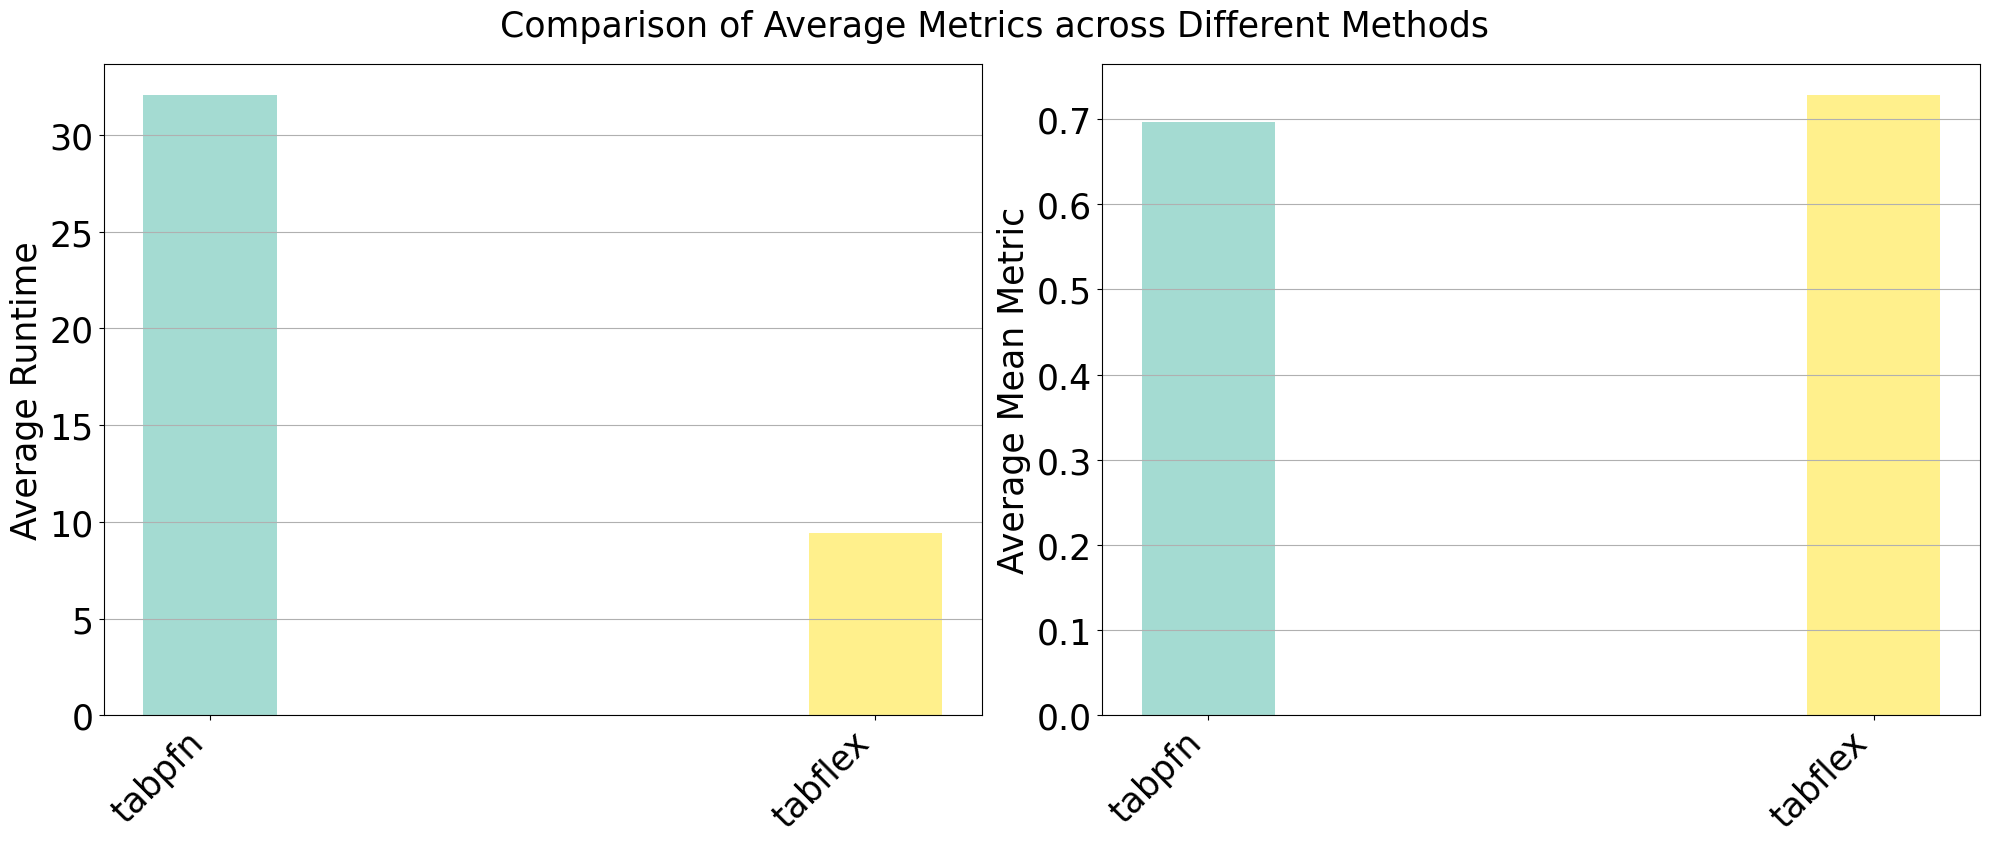

In [46]:
# Calculate averages
metrics = ['runtime', 'mean_metric']
methods = ['tabpfn', 'tabflex']

averages = {metric: {method: combined_table[f'{method}_{metric}'].mean() for method in methods} for metric in metrics}

# Prepare for plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
width = 0.2
x = np.arange(len(methods))

# Color map for consistency across subplots
colors = plt.cm.get_cmap('Set3')(np.linspace(0, 1, len(methods)))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics):

    ax = axes[i]
    values = [averages[metric][method] for method in methods]
    print(x)
    bars = ax.bar(x, values, width, alpha=0.8, color=colors)
    
    ax.set_ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=25)
    ax.tick_params(axis='y', labelsize=25)
    # ax.set_title(f'Comparison of {metric.replace("_", " ").title()}', fontsize=25)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=25)
    ax.yaxis.grid(True)
    
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        # ax.text(bar.get_x() + bar.get_width()/2., height,
        #         f'{height:.6f}',
        #         ha='center', va='bottom', rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Comparison of Average Metrics across Different Methods', fontsize=25, y=1.05)
plt.show()

In [30]:
averages[metric]['tabflex']

0.7226711227613338